# An Upper Limit Howto

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, norm, chi2
from scipy.optimize import minimize

We begin with defining our example. We have two spectra; a bump-like signal spectra upon the smooth background spectra. The parameters of this toy example are the two normalisation of these two components.

We assume that the data are a measured number of events in $n=30$ energy bins, and define a data generating function.

In [ ]:
E = np.logspace(0,2,30+1)
E = (E[1:] + E[:-1]) / 2 # bin centers

def signal_shape(E=E, mu=10, var=2):
    return norm.pdf(E, mu, var)

def background_shape(E=E, gamma=-1):
    return E**gamma

def generate_data(bkg_norm, sig_norm, E=E, seed=None):
    np.random.seed(seed)
    return np.random.poisson(bkg_norm * signal_shape(E) + 
                             sig_norm * background_shape(E))

It's hard to visualise so we plot a realisation of the toy example.

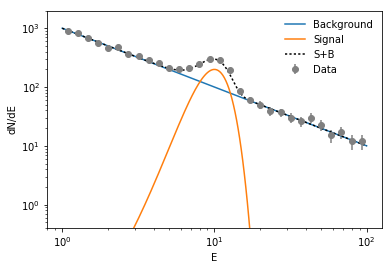

In [57]:
def visualise_model(bkg_norm, sig_norm):
    fig, ax = plt.subplots()
    x = np.logspace(0,2,200)
    b = bkg_norm*background_shape(x)
    s = sig_norm*signal_shape(x)
    ax.plot(x, b, label='Background')
    ax.plot(x, s, label='Signal')
    ax.plot(x, s+b, color='black', linestyle='dotted', label='S+B')

    N = generate_data(bkg_norm, sig_norm)
    ax.errorbar(E, N, yerr=np.sqrt(N), fmt='o', color='grey', label='Data')
    ax.set_ylim(0.4, 2*np.maximum(s.max(), b.max()))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('E')
    ax.set_ylabel('dN/dE')
    ax.legend(frameon=False)
    return fig, ax

visualise_model(bkg_norm=1000, sig_norm=1000);

## Defining the likelihood and the test statistics

The likelihood is simply the product of poisson distributions for each bin.

In [ ]:
def lnLike(bkg_norm, sig_norm, data, gamma=-1, mu=10, var=2):
    s = sig_norm*signal_shape(mu=mu, var=var)
    b = bkg_norm*background_shape(gamma=gamma)
    return np.log(poisson.pmf(data, mu=s+b)).sum()

def TS(sig_norm, data, bestfit=None):
    numerator = minimize(lambda b: -2*lnLike(b, sig_norm, data), 1e3)
    if not bestfit:
        bestfit = minimize(lambda x: -2*lnLike(x[0], x[1], data), (1e3,1e3))
    return numerator.fun - bestfit.fun

## Visualising the properties of the test statistics

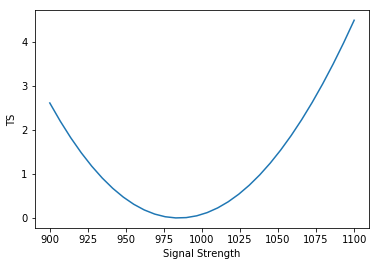

In [62]:
data = generate_data(1000, 1000, seed=42)
bestfit = minimize(lambda x: -2*lnLike(x[0], x[1], data), (1e3,1e3))
x = np.linspace(900, 1100, 30)
y = [TS(s, data, bestfit=bestfit) for s in x]

plt.plot(x, y);
plt.xlabel('Signal Strength')
plt.ylabel('TS');

## Verifying that Wilk's theorem applies

In [84]:
ts_null = []
for _ in range(200):
    d = generate_data(1000, 1000)
    bf = minimize(lambda x: -2*lnLike(x[0], x[1], d), (1e3,1e3))
    r = minimize(lambda s: TS(s, d, bestfit=bf), 1e3)
    ts_null.append(r.fun)
ts_null = np.array(ts_null)

As running the above monte carlo is quite slow, we've stored the results to disk.

In [86]:
np.savetxt('ts_null.txt', ts_null)

In [90]:
ts_null = np.loadtxt('ts_null.txt')

(200,)


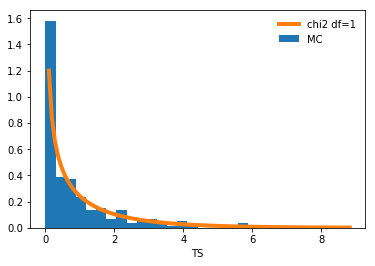

In [89]:
plt.hist(ts_null, bins=30, normed=True, label='MC')
x = np.linspace(0.1, ts_null.max(), 100)
plt.plot(x, chi2.pdf(x, df=1), lw=4, label='chi2 df=1')
plt.legend(frameon=False)
plt.xlabel('TS');
print(ts_null.shape)